# Transferring cell cycle annotation using TransportCorrection

In this tutorial we showcase how data integration can be leveraged to carry out high quality label transfer, and apply it to a practical application in computational biology. Cell cycle is a fundamental biological concept common to all life forms through which biological cells grow and divide. It can be split into chronological phases:

- G1 phase associated with high metabolic activity
- S phase where cell DNA is replicated
- G2 phase associated with high metabolic activity leading to mitosis (M) also known as cell division

Automatic annotation of cell cycle phase of a given cell from transcriptomics is a challenging task, and having to perform biological assays every time is not satisfying either. Label transfer algorithms are used to transfer labels from an annotated dataset to another one. In our case, we will use a single-cell dataset with cell cycle phase annotations from [1], and try to map its labels in a meaningful way on three other unlabeled single-cell datasets from [2,3]. To do so, we first integrate all datasets in a common space using a transmorph model, then perform label transfer using $k$-nearest neighbors in this representation from each dataset to the labeled one. We will use the TransportCorrection model to carry out data integration, as optimal transport is a very natural approach to map a geometrical shape onto another. Its behavior is inspired from SCOT [4].

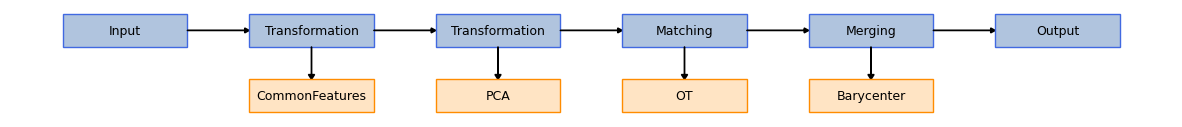

In [1]:
# Loading and fitting the model
from transmorph.models import TransportCorrection
from transmorph.utils.plotting import plot_model

# use_feature_space=True returns a result in  the original genes space
model = TransportCorrection(
    solver="unbalanced", 
    use_feature_space=True, 
    entropy_epsilon=2e-2, # These two parameters should be tweaked 
    unbalanced_reg=5.0
)

plot_model(model)

## Loading datasets

Let us first load the cell cycle databank. It comes already preprocessed, with four single-cell datasets embedding in cell cycle genes space (Tirosh [5] signatures). Each gene is labeled "G1/S" or "G2/M" depending on its contribution to cell cycle phases G1/S or G2/M, and cells from the U2OS dataset are annotated with their respective cell cycle phase. When  carrying out label transfer, it is important to keep in mind that annotation quality will depend on reference dataset quality, so we should always pick good quality datasets to transfer labels from if possible.

In [2]:
from transmorph.datasets import load_cell_cycle

# Format: {batch_key: AnnData}
datasets = load_cell_cycle()

databank_api > Loading bank cell_cycle.
databank_api > Bank cell_cycle successfully loaded.


We can take a look at these four datasets using UMAP first. As we can see, each dataset takes the shape of a ring corresponding to transcriptomic profile progressing through cell cycle trajectory. This visualization is not very informative, we can instead use G1/S and G2/M signal to get a better glance at what cell cycle looks like in each of these datasets.

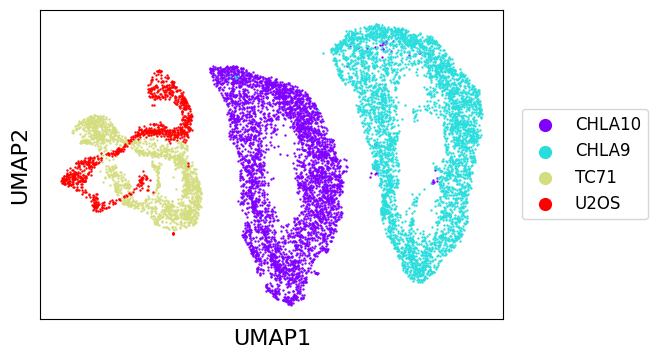

In [3]:
from transmorph.utils.plotting import reduce_dimension, scatter_plot

reduce_dimension(datasets, output_obsm="raw_umap", reducer="umap")

scatter_plot(datasets, use_rep="raw_umap")

## Observing cell cycle

Let us compute for each cell the average expression of its G1/S-related genes and G2/M related genes. We can then use these two values in a 2D coordinates system G1/S-G2/M to unravel and compare cell cycle shape between datasets.

In [4]:
# TC71 and U2OS are "fast" cell cycle datasets.
# Using these genes for G1/S signature yields clearer
# visualizations.
fast_cell_cycle_g1s = [
    'CDK1', 'UBE2C', 'TOP2A', 'TMPO', 'HJURP', 'RRM1', 
    'RAD51AP1', 'RRM2', 'CDC45', 'BLM', 'BRIP1', 'E2F8', 'HIST2H2AC'
]

for name, adata in datasets.items():
    g1s = adata.var_names[adata.var['G1/S gene']]
    g2m = adata.var_names[adata.var['G2/M gene']]
    if name in ["TC71", "U2OS"]:
        g1s = [g for g in g1s if g in fast_cell_cycle_g1s]
    adata.obs['G1/S'] = adata[:, g1s].X.mean(axis=1).copy()
    adata.obs['G2/M'] = adata[:, g2m].X.mean(axis=1).copy()
    # Filtering out a few outliers
    datasets[name] = adata[adata.obs['G2/M'] > -2, :].copy()

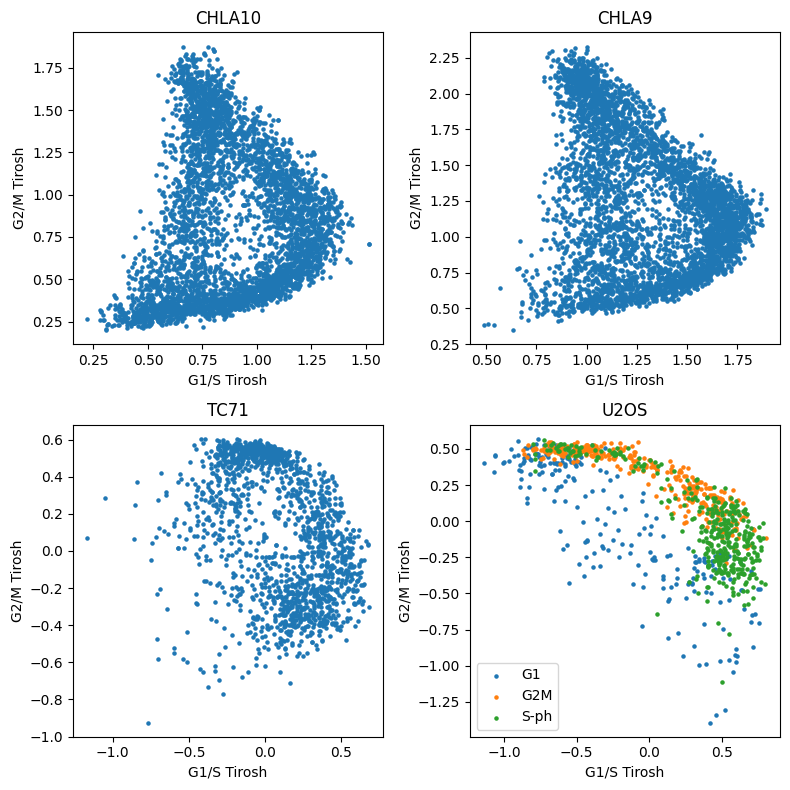

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for i, (name, adata) in enumerate(datasets.items()):
    plt.subplot(2, 2, i+1)
    if name == 'U2OS':
        for label in sorted(set(adata.obs['Cell cycle phase'])):
            if label == "NotAssigned":
                continue
            sel = adata.obs['Cell cycle phase'] == label
            plt.scatter(adata.obs['G1/S'][sel], adata.obs['G2/M'][sel], label=label, s=5)
        plt.legend()
    else:
        plt.scatter(adata.obs['G1/S'], adata.obs['G2/M'], s=5)
    plt.title(name)
    plt.xlabel("G1/S Tirosh")
    plt.ylabel("G2/M Tirosh")
plt.tight_layout()

We can already see these datasets display strong geometrical differences. CHLA9 and CHLA10 are cell lines associated with "normal" cell cycle, with cells scattered uniformly all around a triangular trajectory. Cell cycle progression follows an anti-clockwise sense, with G1/S genes expression increasing, then G2/M genes expression increasing, then mitosis leading to a coming back to the bottom left corner. U2OS and TC71 are associated with a "fast" cell cycle profile, with a cell cycle loop much more shrinked and where cells never go back to lower cell cycle genes expression values. We also notice counts have not been processed identically, CHLA9/CHLA10 being simply log-normalized while TC71/U2OS counts being z-scores, which is a good stress test for integration methods. 

## Performing integration and label transfer

### Transport correction

The idea here will be to integrate all datasets in a common representation using CHLA10 as a reference due to it being apparently of high quality (large number of cells, well resolved cell cycle shape). Once integration has been performed, label transfer from U2OS can be carried out using for instance a $k$-nearest neighbors model from every dataset to U2OS cells. Predicted labels can eventually be displayed on these cell cycle plots, and validated using cell cycle phase interpretation. We notice U2OS has very few G1 points compared to what seems to be G1 in CHLA9 and CHLA10. For this reason, we will use the unbalanced optimal tranport formulation to carry out TransportCorrection matching step; this algorithm requires to tune two parameters:
- Entropy regularizer $\varepsilon$ allows to tweak OT approximation precision, the lower the more precise
- Mass conservation penalty $\delta$ which monitors how much mass conservation matters in the objective function. The lower, the less mass needs to be transported, enforcing global geometry instead.

In [6]:
model.transform(datasets, reference=datasets["CHLA10"])

MNN_CORRECTION > Transmorph model is initializing.
MNN_CORRECTION > Ready to start the integration of 4 datasets, 11100 total samples.
MNN_CORRECTION > Running layer LAYER_INPUT#0.
MNN_CORRECTION > Running layer LAYER_TRANSFORMATION#1.
MNN_CORRECTION > Running layer LAYER_TRANSFORMATION#2.
MNN_CORRECTION > Running layer LAYER_MATCHING#3.
LAYER_MATCHING#3 > Calling matching MATCHING_OT.
MNN_CORRECTION > Running layer LAYER_MERGING#4.
LAYER_MERGING#4 > Running merging MERGING_BARYCENTER...
MNN_CORRECTION > Running layer LAYER_OUTPUT#5.
MNN_CORRECTION > Terminated. Total embedding shape: (11100, 91)
MNN_CORRECTION > Results have been written in AnnData.obsm['X_transmorph'].


Let us display the integrated datasets in their new G1/S-G2/M representation, guided by CHLA10 shape. This representation will be used to transfer labels from U2OS to the other datasets. We can extract feature names used in the final representation from TransportCorrection.embedding_features, and gather corrected counts from each AnnData in the "transmorph" obsm field.

In [7]:
# TC71 and U2OS are "fast" cell cycle datasets.
# Using these genes for G1/S signature yields clearer
# visualizations.
fast_cell_cycle_g1s = [
    'CDK1', 'UBE2C', 'TOP2A', 'TMPO', 'HJURP', 'RRM1', 
    'RAD51AP1', 'RRM2', 'CDC45', 'BLM', 'BRIP1', 'E2F8', 'HIST2H2AC'
]

embedding_genes = model.embedding_features

for name, adata in datasets.items():
    g1s_genes = [g for g in embedding_genes if datasets['CHLA10'].var.loc[g]['G1/S gene']]
    g2m_genes = [g for g in embedding_genes if datasets['CHLA10'].var.loc[g]['G2/M gene']]
    if name in ['U2OS', 'TC71']: # Fast cell cycle
        g1s_genes = [g for g in g1s_genes if g in fast_cell_cycle_g1s]
    g1s_indices = [g in g1s_genes for g in embedding_genes]
    g2m_indices = [g in g2m_genes for g in embedding_genes]
    adata.obs['G1/S_tr'] = adata.obsm['X_transmorph'][:, g1s_indices].mean(axis=1)
    adata.obs['G2/M_tr'] = adata.obsm['X_transmorph'][:, g2m_indices].mean(axis=1)
    # Filtering out a few outliers
    datasets[name] = adata[adata.obs['G2/M'] > -2, :].copy()

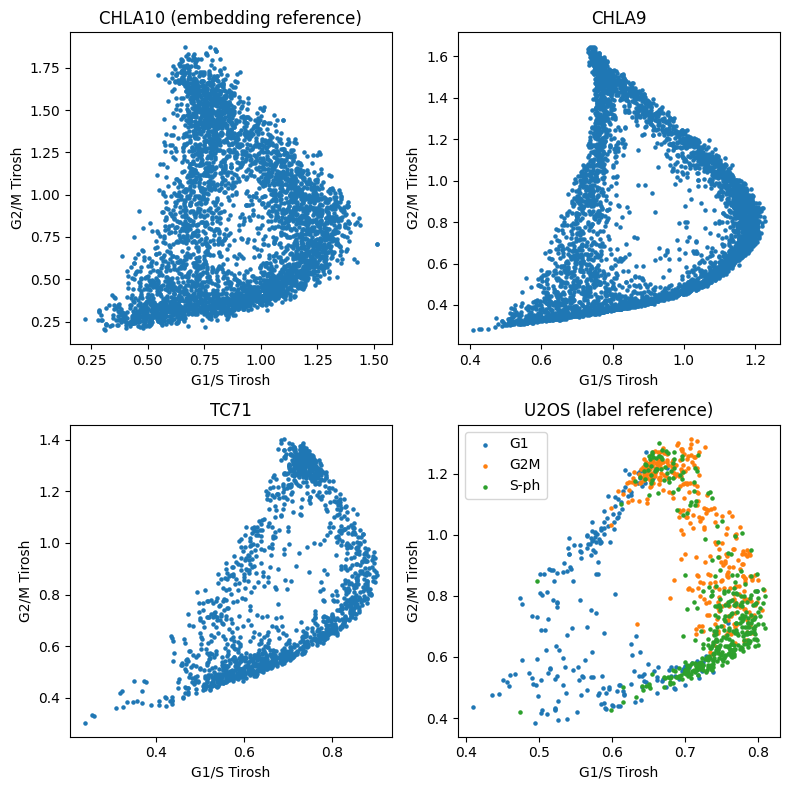

In [8]:
plt.figure(figsize=(8,8))
for i, (name, adata) in enumerate(datasets.items()):
    plt.subplot(2, 2, i+1)
    if name == "U2OS":
        for label in sorted(set(adata.obs['Cell cycle phase'])):
            if label == "NotAssigned":
                continue
            sel = adata.obs['Cell cycle phase'] == label
            plt.scatter(adata.obs['G1/S_tr'][sel], adata.obs['G2/M_tr'][sel], label=label, s=5)
        name += " (label reference)"
        plt.legend()
    else:
        plt.scatter(adata.obs['G1/S_tr'], adata.obs['G2/M_tr'], s=5)
    if name == "CHLA10":
        name += " (embedding reference)"
    plt.title(name)
    plt.xlabel("G1/S Tirosh")
    plt.ylabel("G2/M Tirosh")
plt.tight_layout()

### Label transfer

As we can see, all datasets now look way more similar both in terms of shape and scale, and U2OS cell cycle annotations seem decently separated along the trajectory. Label transfer can therefore be carried out using a simple $k$-nearest neighbors algorithmic scheme. We can then use inferred labels in the original embedding spaces.

In [9]:
# Custom label transfer algorithm

from sklearn.neighbors import NearestNeighbors
import numpy as np

def label_transfer(
    adatas, 
    ref_adata,
    obs_label: str,
    use_rep: str = "transmorph",
    n_neighbors: int = 10
) -> None:
    """
    Transfers ref_adata labels onto all AnnDatas after integration via nearest neighbors.
    """
    if isinstance(adatas, dict):
        adatas = adatas.values()
    nn = NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(ref_adata.obsm[use_rep])
    # For each non-U2OS AnnData, we transfer U2OS labels onto it using
    # k-nearest neighbors.
    for adata in adatas:
        if adata is ref_adata:
            continue
        indices = nn.kneighbors(adata.obsm[use_rep], return_distance=False)
        prediction = []
        prediction_confidence = []
        for i in range(adata.n_obs):
            labels = np.array(ref_adata.obs[obs_label][indices[i]])
            counts = {}
            for label in labels:
                if label not in counts:
                    counts[label] = 0
                counts[label] += 1
            top_label = max(counts.keys(), key=lambda k: counts[k])
            prediction.append(top_label)
            prediction_confidence.append(counts[top_label]/sum(counts.values()))
        adata.obs[obs_label] = prediction
        adata.obs[f'{obs_label} (confidence)'] = prediction_confidence
        
label_transfer(datasets, datasets['U2OS'], 'Cell cycle phase')

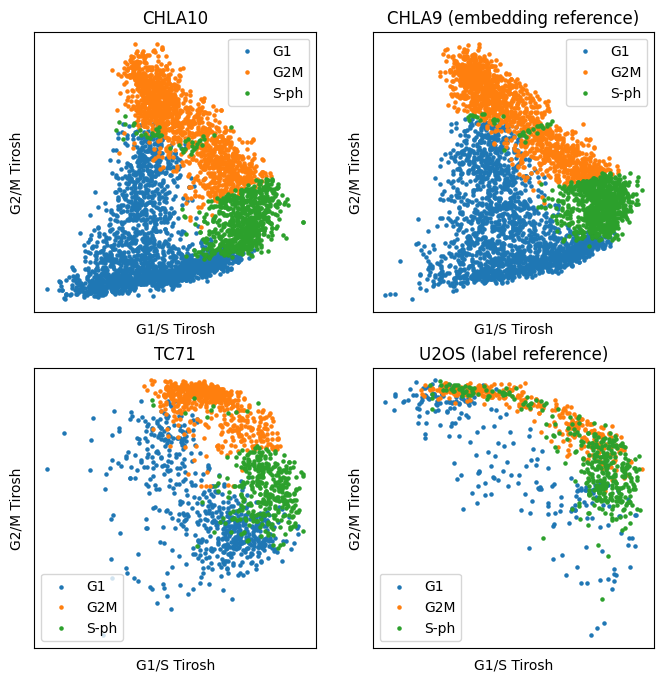

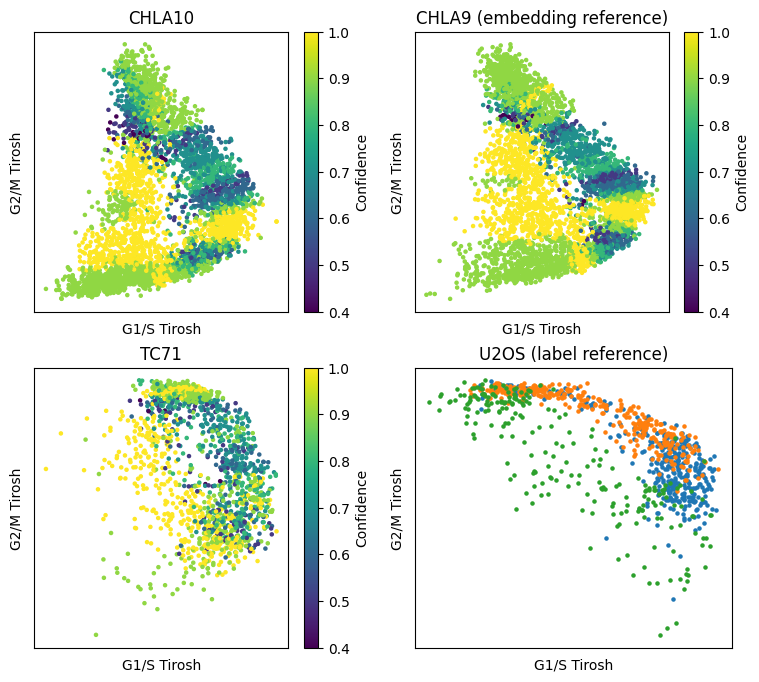

In [10]:
# New annotation
plt.figure(figsize=(8,8))
for i, (name, adata) in enumerate(datasets.items()):
    plt.subplot(2, 2, i+1)
    for label in sorted(set(adata.obs['Cell cycle phase'])):
        if label == "NotAssigned":
            continue
        sel = adata.obs['Cell cycle phase'] == label
        plt.scatter(adata.obs['G1/S'][sel], adata.obs['G2/M'][sel], label=label, s=5)
    if name == "U2OS":
        name += " (label reference)"
    if name == "CHLA9":
        name += " (embedding reference)"
    plt.title(name)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("G1/S Tirosh")
    plt.ylabel("G2/M Tirosh")
    plt.legend()

# Confidence
plt.figure(figsize=(9,8))
for i, (name, adata) in enumerate(datasets.items()):
    plt.subplot(2, 2, i+1)
    if name == "U2OS":
        for label in set(adata.obs['Cell cycle phase']):
            if label == "NotAssigned":
                continue
            sel = adata.obs['Cell cycle phase'] == label
            plt.scatter(adata.obs['G1/S'][sel], adata.obs['G2/M'][sel], label=label, s=5)
        name += " (label reference)"
    else:
        if name == "CHLA9":
            name += " (embedding reference)"
        plt.scatter(adata.obs['G1/S'], adata.obs['G2/M'], c=adata.obs['Cell cycle phase (confidence)'], s=5)
        cbar = plt.colorbar()
        cbar.ax.set_ylabel("Confidence")
    plt.title(name)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("G1/S Tirosh")
    plt.ylabel("G2/M Tirosh")

As we can see, inferred labels are very close to what we would expect in reality: G2/M descending and G1/S ascending phases labeled as G1 cells, bottom right turn labeled, as S phase, G2/M ascending phase labeled as G2. This shows how we can leverage dataset integration using transmorph to transfer labels between datasets in a biologically relevant manner.

#### References

[1] Mahdessian, Diana, et al. *Spatiotemporal dissection of the cell cycle with single-cell proteogenomics.* **Nature** 590.7847 (2021): 649-654.

[2] Miller, Henry E., et al. *Reconstruction of Ewing sarcoma developmental context from mass-scale transcriptomics reveals characteristics of EWSR1-FLI1 permissibility.* **Cancers** 12.4 (2020): 948.

[3] Demetci, Pinar, et al. *SCOT: Single-cell multi-omics alignment with optimal transport.* **Journal of Computational Biology** 29.1 (2022): 3-18.

[4] Patel, Anoop P., et al. *Single-cell RNA-seq highlights intratumoral heterogeneity in primary glioblastoma.* **Science** 344.6190 (2014): 1396-1401.